In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import optuna

from datetime import datetime, timedelta

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.arima.model import ARIMA


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
np.random.seed(1)

Задача 1. Прогнозування

Основна мета цього блоку реалізувати систему прогнозування попиту на короткостроковий період (14 днів) через 7 днів від останньої дати в даних, для всіх груп товарів. Базуємось на наданих вам даних про транзакції. Важливо врахувати, щоб система могла видавати прогноз для товарів-новачків (у яких було мало данних при навчанні або вони були зовсім відсутні). Ми б хотіли бачити 2 підходи для порівняння: за допомогою машинного навчання та класичного прогнозування часових рядів.

Технічне рішення повинно бути обгрунтоване коментарями, стосовно доцільності того чи іншого методу, підходу.

Як результат: Файл (.py/.ipynb) з технічним рішенням по прогнозуванню. Даний функціонал повинен мати можливість проводити розрахунок результату на майбутній період (scoring). 

In [2]:
FOLDER = '/kaggle/input/test-assigment-smart-it/' # change to your folder path

order_payments = pd.read_csv(FOLDER + 'order_payments.csv')
order_items = pd.read_csv(FOLDER + 'order_items.csv')
orders = pd.read_csv(FOLDER + 'orders.csv')
sellers = pd.read_csv(FOLDER + 'sellers.csv')
products = pd.read_csv(FOLDER + 'products.csv')
product_category_name_translation = pd.read_csv(FOLDER + 'product_category_name_translation.csv')

## Extend order_items.csv with useful columns

In [3]:
order_items = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
order_items = pd.merge(order_items, orders[['order_id', 'order_purchase_timestamp']], on='order_id')
order_items['total_price'] = order_items['price'] + order_items['freight_value']

order_items = order_items.sort_values('order_purchase_timestamp')
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date']).dt.date
order_items['order_purchase_timestamp'] = pd.to_datetime(order_items['order_purchase_timestamp']).dt.date

order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_purchase_timestamp,total_price
20265,2e7a8482f6fb09756ca50c10d7bfc047,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26,39.99,31.67,moveis_decoracao,2016-09-04,71.66
20266,2e7a8482f6fb09756ca50c10d7bfc047,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26,32.90,31.67,moveis_decoracao,2016-09-04,64.57
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19,59.50,15.56,telefonia,2016-09-05,75.06
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19,44.99,2.83,beleza_saude,2016-09-15,47.82
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19,44.99,2.83,beleza_saude,2016-09-15,47.82


# Define functions for processing

In [4]:
def determine_date_list(order_items):
    """
    Make list of 48 dates with range 2 weeks
    betweem each one. From last date in order_items.csv
    If there are two dates 2022 and 2024, last is 2024
    """
    
    new_date = order_items['order_purchase_timestamp'].max() 
    weeks_from_new_to_old_date = 48
    
    date_list = [new_date - timedelta(weeks=x*2) for x in range(weeks_from_new_to_old_date)]
    date_list.reverse()
    
    return date_list

In [5]:
date_list = determine_date_list(order_items)
print(date_list[:5])

[datetime.date(2016, 11, 14), datetime.date(2016, 11, 28), datetime.date(2016, 12, 12), datetime.date(2016, 12, 26), datetime.date(2017, 1, 9)]


In [6]:
def find_closest_date(target_date, date_list):
    newest_date = max(date_list)
    if target_date > newest_date:
        print(f'Error. target_date({target_date}) cannot be bigger than the bigger date({newest_date}) in list.')
        return -1
    
    days_diff = (newest_date - target_date).days
    weeks = days_diff // 14
    
    closest_date = newest_date - timedelta(weeks=weeks * 2)
    
    # !!!
    # if date is much older than first date from list 
    # closest date is set as first date in list
    if closest_date not in date_list:
        return date_list[0]
    
    return closest_date


target_test_date = order_items.loc[8, 'order_purchase_timestamp']
closest_date = find_closest_date(target_test_date, date_list)
print(f"The closest date to {target_test_date} is {closest_date}")

The closest date to 2018-03-19 is 2018-03-19


In [7]:
target_test_date = order_items.loc[20265, 'order_purchase_timestamp']
closest_date = find_closest_date(target_test_date, date_list)
print(f"The closest date to {target_test_date} is {closest_date}")

The closest date to 2016-09-04 is 2016-11-14


In [8]:
class Product: 
    def __init__(self, added_date, first_price):
        self.added_date = added_date
        self.first_price = first_price
        self.__last_price = first_price
        self.last_sold_date = added_date
        self.price_decreased_n = 0
        self.price_increased_n = 0 
        self.is_last_price_decreased = False
        self.is_last_price_increased = False
     
    @property
    def last_price(self): 
         return self.__last_price 
        
    @last_price.setter
    def last_price(self, value):
        if value < self.__last_price:
            self.is_last_price_decreased = True
            self.is_last_price_increased = False
            self.price_decreased_n += 1
        elif value > self.__last_price:
            self.is_last_price_decreased = False
            self.is_last_price_increased = True
            self.price_increased_n += 1
        else:
            self.is_last_price_decreased = False
            self.is_last_price_increased = False
        
        self.__last_price = value

## Function make_products_weekly_Xy is used for training. It uses last column (2 weeks) as y (target prediction), make_products_weekly_X is used for future prediction, it uses full data as X to make predictions.

In [9]:
def make_weekly_frame_with_unique_products(order_items):
    unique_products_df = order_items[['product_id', 'product_category_name']].drop_duplicates(subset='product_id')
    unique_products_df[date_list] = 0

    weekly_product_df = unique_products_df

    weekly_product_df.set_index(['product_id'], inplace=True)
    weekly_product_df.fillna(0, inplace=True)
    
    return weekly_product_df

    
def make_products_weekly_Xy(order_items):
    weekly_product_df = make_weekly_frame_with_unique_products(order_items)

    target_date = date_list[-1]
    y = weekly_product_df[target_date]
    X = weekly_product_df.drop(target_date, axis=1)

    products = {}

    for _, row in order_items.iterrows():
        product_id = row['product_id']
        total_price = row['total_price']
        order_date = find_closest_date(row['order_purchase_timestamp'], date_list)
        
        # to exclude all orders with target_date for processing only previous dates
        if order_date == target_date:
            if products.get(product_id) == None:
                # if first purchase of product_id was in target_date, it will be excluded,
                # because we cant train and predict on target_date
                if product_id in X.index:
                    X = X.drop(product_id, axis=0)
                    y = y.drop(product_id, axis=0)
                continue
            else:
                y.at[product_id] += 1
                continue

        if products.get(product_id) == None:
            added_date_n = date_list.index(order_date)
            products[product_id] = Product(added_date_n, total_price)
        else:
            products[product_id].last_price = total_price
            products[product_id].last_sold_date = date_list.index(order_date)

        X.at[product_id, order_date] += 1
        
    return X, y, products


def make_products_weekly_X(order_items):
    weekly_product_df = make_weekly_frame_with_unique_products(order_items)

    X = weekly_product_df

    products = {}

    for _, row in order_items.iterrows():
        product_id = row['product_id']
        total_price = row['total_price']
        order_date = find_closest_date(row['order_purchase_timestamp'], date_list)
        
        if products.get(product_id) == None:
            added_date_n = date_list.index(order_date)
            products[product_id] = Product(added_date_n, total_price)
        else:
            products[product_id].last_price = total_price
            products[product_id].last_sold_date = date_list.index(order_date)

        X.at[product_id, order_date] += 1
        
    return X, products

In [10]:
feature_list = ['added_date', 'last_sold_date', 'first_price', 'last_price',
                 'price_decreased_n', 'price_increased_n', 'is_last_price_decreased',
                 'is_last_price_increased', 'active_2weeks_selling', 
                 'non_active_2weeks_selling', 'last_selling_streak', 'avg_selling']

def processing_featuring_weekly_frame(X, products):
    for feature in feature_list:
        X.insert(loc=0, column=feature, value=0)
        
    for _, row in X.iterrows():
        product = products[_]

        X.at[_, 'added_date'] = product.added_date
        X.at[_, 'last_sold_date'] = product.last_sold_date
        X.at[_, 'first_price'] = product.first_price
        X.at[_, 'last_price'] = product.last_price
        X.at[_, 'price_decreased_n'] = product.price_decreased_n
        X.at[_, 'price_increased_n'] = product.price_increased_n
        X.at[_, 'is_last_price_decreased'] = product.is_last_price_decreased
        X.at[_, 'is_last_price_increased'] = product.is_last_price_increased

        n_date_cols = len(feature_list)+1 
        X.at[_, 'active_2weeks_selling'] = (row[n_date_cols:] > 0).sum()
        X.at[_, 'non_active_2weeks_selling'] =  product.last_sold_date + 1 - product.added_date - X.loc[_, 'active_2weeks_selling']
        
        row_ = row[n_date_cols:][product.added_date:]
        X.at[_, 'avg_selling'] = sum(row_) / len(row_)

        row_ = row[n_date_cols:] > 0
        last_selling_streak = 0
        for active_weeks in row_[::-1]:
            if active_weeks > 0:
                last_selling_streak += 1
            if active_weeks == 0 and last_selling_streak != 0:
                break
        
        X.at[_, 'last_selling_streak'] = last_selling_streak

In [11]:
def rename_date_columns(X, y=None):
    data = None
    
    if y is None:
        data = X
    else:
        data = pd.merge(X, y, on='product_id')
       
    dict_renamed_date_cols = {date: i for i, date in enumerate(data.columns[len(feature_list)+1:])}
    return data.rename(columns=dict_renamed_date_cols)

# Process data for training and test

In [12]:
X, y, products = make_products_weekly_Xy(order_items)
processing_featuring_weekly_frame(X, products)
train_data_renamed_cols = rename_date_columns(X, y)

/tmp/ipykernel_33/1919828964.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '71.66' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.at[_, 'first_price'] = product.first_price
/tmp/ipykernel_33/1919828964.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '58.379999999999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.at[_, 'last_price'] = product.last_price
/tmp/ipykernel_33/1919828964.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.at[_, 'is_last_price_decreased'] = product.is_last_price_decreased
/tmp/ipykernel_33/1919828964.py:20: FutureWarni

In [13]:
X.head(3)

,avg_selling,last_selling_streak,non_active_2weeks_selling,active_2weeks_selling,is_last_price_increased,is_last_price_decreased,price_increased_n,price_decreased_n,last_price,first_price,last_sold_date,added_date,product_category_name,2016-11-14,2016-11-28,2016-12-12,2016-12-26,2017-01-09,2017-01-23,2017-02-06,2017-02-20,2017-03-06,2017-03-20,2017-04-03,2017-04-17,2017-05-01,2017-05-15,2017-05-29,2017-06-12,2017-06-26,2017-07-10,2017-07-24,2017-08-07,2017-08-21,2017-09-04,2017-09-18,2017-10-02,2017-10-16,2017-10-30,2017-11-13,2017-11-27,2017-12-11,2017-12-25,2018-01-08,2018-01-22,2018-02-05,2018-02-19,2018-03-05,2018-03-19,2018-04-02,2018-04-16,2018-04-30,2018-05-14,2018-05-28,2018-06-11,2018-06-25,2018-07-09,2018-07-23,2018-08-06,2018-08-20
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1488892604e4ba5cff5b4eb4d595400,0.595745,2,5,13,True,False,9,9,58.38,71.66,17,0,moveis_decoracao,3,0,0,0,2,2,1,0,2,1,3,1,3,3,2,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f293394c72c9b5fafd7023301fc21fc2,0.021277,1,0,1,False,False,0,0,64.57,64.57,0,0,moveis_decoracao,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f3c2d01a84c947b078e32bbef0718962,0.021277,1,0,1,False,False,0,0,75.06,75.06,0,0,telefonia,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
train_data_renamed_cols.head(3)

,avg_selling,last_selling_streak,non_active_2weeks_selling,active_2weeks_selling,is_last_price_increased,is_last_price_decreased,price_increased_n,price_decreased_n,last_price,first_price,last_sold_date,added_date,product_category_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1488892604e4ba5cff5b4eb4d595400,0.595745,2,5,13,True,False,9,9,58.38,71.66,17,0,moveis_decoracao,3,0,0,0,2,2,1,0,2,1,3,1,3,3,2,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f293394c72c9b5fafd7023301fc21fc2,0.021277,1,0,1,False,False,0,0,64.57,64.57,0,0,moveis_decoracao,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f3c2d01a84c947b078e32bbef0718962,0.021277,1,0,1,False,False,0,0,75.06,75.06,0,0,telefonia,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Split data for training, validation, test

## Below you will see stats of last two weeks products turnover for which we will be making prediction. 

In [15]:
target = train_data_renamed_cols.columns[-1]

active_two_weeks = train_data_renamed_cols[train_data_renamed_cols[target] > 0]

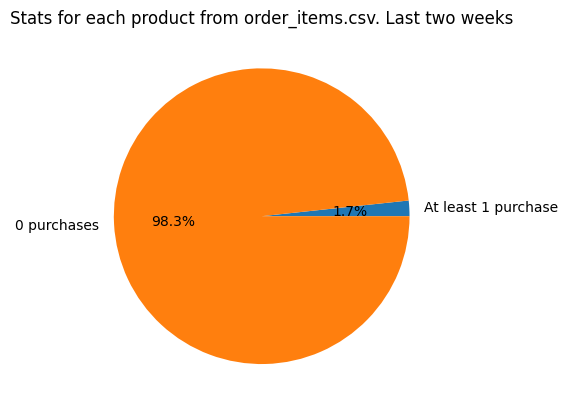

In [16]:
fig, ax = plt.subplots()
ax.pie([len(active_two_weeks), len(X) - len(active_two_weeks)],
       labels=['At least 1 purchase', '0 purchases'],
       autopct='%1.1f%%')
ax.set(title='Stats for each product from order_items.csv. Last two weeks')

plt.show()

## There is a lot products that havent been purchased in last 2 weeks, so I will balance dataset by removing big part, so that model can learn how to predict not only zero values

In [17]:
n_empty_two_weeks = int(active_two_weeks.shape[0] * 1.25)
empty_two_weeks = train_data_renamed_cols[train_data_renamed_cols[target] == 0].sample(n_empty_two_weeks, random_state=1)
mixed_data = pd.concat([empty_two_weeks, active_two_weeks]).sample(frac=1, random_state=1)

y_ = mixed_data[target]
X_ = mixed_data.drop(target, axis=1)


X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=1)

print(f'Number of rows in dataset for \nTraining: {len(X_train)}\nValidation: {len(X_valid)}\nTest: {len(X_test)}')

Number of rows in dataset for 
Training: 747
Validation: 249
Test: 250


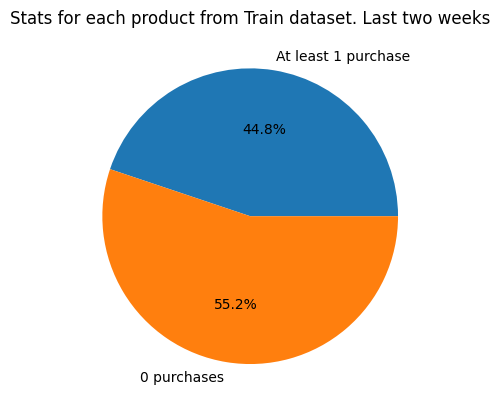

In [18]:
fig, ax = plt.subplots()
ax.pie([sum(y_train > 0), sum(y_train ==0)],
       labels=['At least 1 purchase', '0 purchases'],
       autopct='%1.1f%%')
ax.set(title='Stats for each product from Train dataset. Last two weeks')

plt.show()

# Fitting models and calculating scores. 

Using RMSE score (Average error between real and predicted values).
Lower score is better.

## First model is classic statistical model ARIMA (Autoregressive integrated moving average)

In [19]:
def arima_predictions(data, from_date):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        preds = []
        X_date_only = data.drop(feature_list, axis=1).drop(['product_category_name'], axis=1)
        
        from_date_index = list(X_date_only.columns).index(from_date)
        X_date_only = X_date_only[X_date_only.columns[from_date_index:]]
        
        for _, row in X_date_only.iterrows():            
            arima = ARIMA(row, order=(2, 1, 1), trend='n')
            result = arima.fit()

            predictions = result.predict(len(row) , len(row)).iloc[0]
            if predictions is None:
                print('Error with prediction for:', _)
                preds.append(0)
            else:
                preds.append(predictions)
            
        return preds

In [20]:
X_test_renamed_with_dates = X_test.rename(columns={c: date_list[c] for c in X_test.columns[len(feature_list)+1:]})


arima_preds = arima_predictions(X_test_renamed_with_dates, from_date=date_list[0])
arima_preds_rounded = [round(i) for i in arima_preds]

arima_score = mean_squared_error(y_test, arima_preds_rounded, squared=False)
print('ARIMA score with metric RMSE is', arima_score)

ARIMA score with metric RMSE is 1.1916375287812984


## Second model is CatBoostRegressor. Machine learning approach

In [21]:
model = CatBoostRegressor(loss_function='RMSE', depth=4, learning_rate=0.01, iterations=2000, random_seed=1)

model.fit(
    X_train, y_train,
    use_best_model=True,
    cat_features=['product_category_name'],
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=50,
    verbose=False,
)

cat_boost_preds_rounded = [round(i) for i in model.predict(X_test)]
cat_boost_score = mean_squared_error(y_test, cat_boost_preds_rounded, squared=False)
print("CatBoostRegressor model's score with metric RMSE is", cat_boost_score)

CatBoostRegressor model's score with metric RMSE is 0.6164414002968976


## See some predicted turnover of products for two weeks

In [22]:
preds_df = pd.DataFrame({'true':y_test, 'predicted':[round(i) for i in model.predict(X_test)]})

pd.concat([preds_df[preds_df['true'] > 0][:10], preds_df[preds_df['true'] == 0][:10]])

,true,predicted
product_id,,
3d13b6c4a341d28974fbf776957250b0,2,1
d2c7a1e57b8f3e74095798f867334b36,1,1
bdef7736f61a507f68b31bd86ddaf69d,1,0
c7944f654db61924bb81f0e3160ab757,1,1
3fbc0ef745950c7932d5f2a446189725,4,2
08bcc2d85da3a9c0e2ac1cc28b67418d,1,1
2715967684d6991f7501693bfe08c08b,1,0
3ae3ff1822dea42b242b5902e605c1bd,1,0
2ae94d219369eb83f204effd82cb9f31,1,0


## Feature importance of catboostregressor model

Columns named like 46, 37, 44 are dates.(Higher number is closest date to predicted date, predicted date is 47) Its renamed so that it will be easier in future to fit data in this model.

Text(0.5, 1.0, 'Feature Importance')

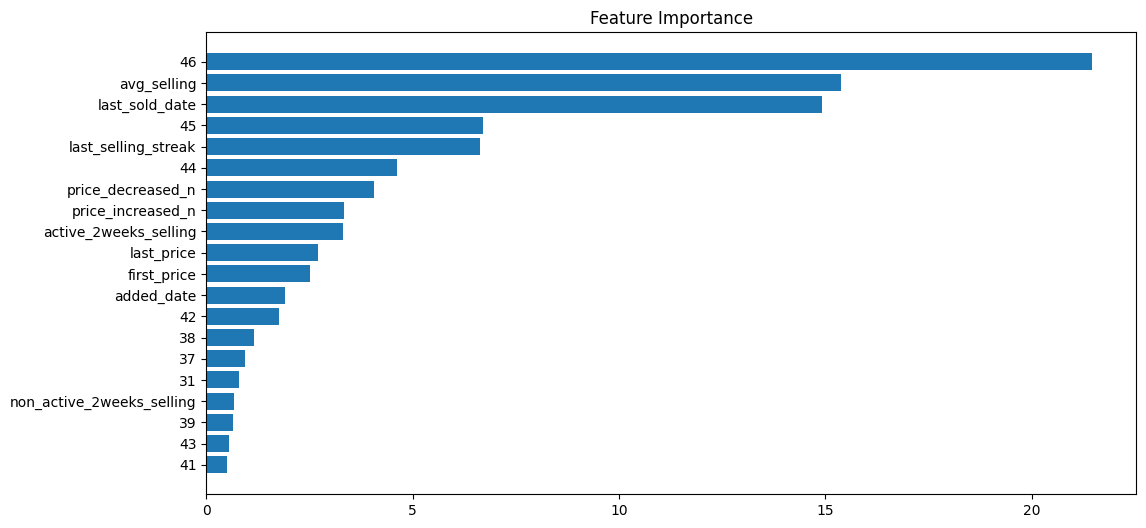

In [23]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[40:]

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_valid.columns)[sorted_idx])
plt.title('Feature Importance')

# For future predictions

In [24]:
future_order_items = order_items.sample(3, random_state=1)

one_product_full_history = order_items[order_items['product_id'] == '3429d7e4892a2df967fae671f4c98deb']
new_added_product = ['test_order_id', 1, 'test_product_id', 'c731d18cea9bf687ffee82a241c25b112017',
                     date_list[-1], 10.0, 12.0, 'la_cuisine', date_list[-1], 22.0]

future_order_items = pd.concat([future_order_items, one_product_full_history])
future_order_items.loc[0] = new_added_product
future_order_items.loc[1] = new_added_product

future_order_items.tail(6)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,order_purchase_timestamp,total_price
74182,a90f9ba8f37b93b785af54fd5a52ada5,1,3429d7e4892a2df967fae671f4c98deb,900ba814c251a692506d7834c1218441,2018-04-26,370.47,18.48,beleza_saude,2018-04-21,388.95
81202,b88d2770687ac406cf224922ace6db95,1,3429d7e4892a2df967fae671f4c98deb,900ba814c251a692506d7834c1218441,2018-04-25,370.47,40.31,beleza_saude,2018-04-21,410.78
9489,15b5597f4ace3db6ea01c54d433187ce,1,3429d7e4892a2df967fae671f4c98deb,900ba814c251a692506d7834c1218441,2018-07-18,370.47,43.57,beleza_saude,2018-07-13,414.04
21370,30e934394c047a409bb861a9ecbcff43,1,3429d7e4892a2df967fae671f4c98deb,900ba814c251a692506d7834c1218441,2018-08-14,370.47,17.89,beleza_saude,2018-08-09,388.36
0,test_order_id,1,test_product_id,c731d18cea9bf687ffee82a241c25b112017,2018-09-03,10.00,12.00,la_cuisine,2018-09-03,22.00
1,test_order_id,1,test_product_id,c731d18cea9bf687ffee82a241c25b112017,2018-09-03,10.00,12.00,la_cuisine,2018-09-03,22.00


In [25]:
date_list = determine_date_list(future_order_items)

# need to remove one value because model was trained
# on 47 dates (date 48 was as y(target) for training)
date_list.pop(0)
len(date_list)

47

In [26]:
X, products = make_products_weekly_X(future_order_items)
processing_featuring_weekly_frame(X, products)
train_data_renamed_cols = rename_date_columns(X)

/tmp/ipykernel_33/1919828964.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.72' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.at[_, 'first_price'] = product.first_price
/tmp/ipykernel_33/1919828964.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.72' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.at[_, 'last_price'] = product.last_price
/tmp/ipykernel_33/1919828964.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.at[_, 'is_last_price_decreased'] = product.is_last_price_decreased
/tmp/ipykernel_33/1919828964.py:20: FutureWarning: Setting a

In [27]:
train_data_renamed_cols

,avg_selling,last_selling_streak,non_active_2weeks_selling,active_2weeks_selling,is_last_price_increased,is_last_price_decreased,price_increased_n,price_decreased_n,last_price,first_price,last_sold_date,added_date,product_category_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8d51190d4e52d32e6abf3d0551501114,0.024390,1,0,1,False,False,0,0,34.72,34.72,6,6,telefonia,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cc9e875c2df286dbed83efe01191162c,0.034483,1,0,1,False,False,0,0,155.18,155.18,18,18,la_cuisine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
913803e9e4b81c3fed4841cbbfdc59fd,0.071429,1,0,1,False,False,0,0,133.18,133.18,33,33,esporte_lazer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3429d7e4892a2df967fae671f4c98deb,0.535714,1,16,11,False,True,6,4,388.36,388.82,45,19,beleza_saude,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,0,1,0,2,0,0,1,1,0,1,0,0,0,3,0,0,0,0,0,1,0,1,0
test_product_id,2.000000,1,0,1,False,False,0,0,22.00,22.00,46,46,la_cuisine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [28]:
future_test_predictions = [round(i) for i in model.predict(train_data_renamed_cols)]
future_df = pd.DataFrame({'product_id':train_data_renamed_cols.index, 'Predicted future two weeks':future_test_predictions})
future_df

,product_id,Predicted future two weeks
0,8d51190d4e52d32e6abf3d0551501114,0
1,cc9e875c2df286dbed83efe01191162c,0
2,913803e9e4b81c3fed4841cbbfdc59fd,0
3,3429d7e4892a2df967fae671f4c98deb,1
4,test_product_id,1
